In [ ]:
!pip install langchain_mcp_adapters langgraph langchain-openai

# Imports

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import torch

import subprocess
import asyncio
import signal
from contextlib import asynccontextmanager
import os

# Math Server

In [ ]:
%%writefile mcp_server.py
from mcp.server.fastmcp import FastMCP
# Those lines have to be here!

mcp_server = FastMCP("Math")


@mcp_server.tool()
def add(a: float, b: float) -> str:
    """Add two numbers"""
    return f"Tool response: {a} + {b} = {a + b}"


@mcp_server.tool()
def multiply(a: float, b: float) -> str:
    """Multiply two numbers"""
    return f"Tool response: {a} * {b} = {a * b}"


@mcp_server.tool()
def subtract(a: float, b: float) -> str:
    """Subtract two numbers"""
    return f"Tool response: {a} - {b} = {a - b}"


@mcp_server.tool()
def divide(a: float, b: float) -> str:
    """Divide two numbers"""
    if b == 0:
        return "Tool response: Division by zero is not allowed."
    return f"Tool response: {a} / {b} = {a / b}"


@mcp_server.tool()
def square(a: float) -> str:
    """Square a number"""
    return f"Tool response: {a}^2 = {a**2}"


@mcp_server.tool()
def square_root(a: float) -> str:
    """Square root of a number"""
    if a < 0:
        return "Tool response: Square root of negative number is not allowed."
    return f"Tool response: sqrt({a}) = {a**0.5}"


if __name__ == "__main__":
    mcp_server.run(transport="sse")

Overwriting mcp_server.py


# Server Context Manager

In [ ]:
@asynccontextmanager
async def run_server():
    process = subprocess.Popen(["python", "mcp_server.py"])
    try:
        await asyncio.sleep(1)  # give the server a moment to start up
        yield
    finally:
        process.send_signal(signal.SIGINT)
        try:
            process.wait(timeout=5)
        except subprocess.TimeoutExpired:
            process.kill()

# Model definition

In [ ]:
model = ChatOpenAI(
    model="llama-70b",
    base_url="https://url/openai/",
    api_key=""
)

# Define prompt

In [ ]:
prompt = "What's the square root of 6 in addition to 12? Make sure to use one tool after another."

# Nice printing function

In [ ]:
def format_and_print_response(agent_response):
    print("\n=== Agent Response ===\n")
    for message in agent_response["messages"]:
        if isinstance(message, dict):
            # Handle dictionary format
            if message.get("type") == "human":
                print(f"Human: {message.get('content')}")
            elif message.get("type") == "ai":
                print(f"Assistant: {message.get('content')}")
            elif message.get("type") == "tool":
                print(f"Tool: {message.get('tool_name')}")
                print(f"Tool input: {message.get('tool_input')}")
                print(f"Tool output: {message.get('content')}")
        else:
            # Handle LangChain message objects
            if (
                hasattr(message, "__class__")
                and message.__class__.__name__ == "HumanMessage"
            ):
                print(f"Human: {message.content}")
            elif (
                hasattr(message, "__class__")
                and message.__class__.__name__ == "AIMessage"
            ):
                if message.tool_calls:
                    print("Assistant using tools:")
                    for tool_call in message.tool_calls:
                        print(f"  - {tool_call['name']}({tool_call['args']})")
                elif message.content:
                    print(f"Assistant: {message.content}")
            elif (
                hasattr(message, "__class__")
                and message.__class__.__name__ == "ToolMessage"
            ):
                print(f"Tool '{message.name}' returned: {message.content}")
        print()

# Creating and running a ReAct agent

[ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629)

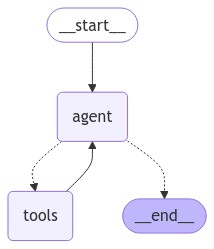

In [ ]:

async def main():
    async with MultiServerMCPClient(
    {
        "math": {
            "url": "http://localhost:8000/sse",
            "transport": "sse",
        }
    }
    ) as session:
            # Create and run the agent
            agent = create_react_agent(model, session.get_tools())
            agent_response = await agent.ainvoke(
                {
                    "messages": prompt
                }
            )
            # Print agent response
            format_and_print_response(agent_response)


async def run_and_main():
    async with run_server():
        await main()

await run_and_main()
